<center><h1>Lewis_Rylan Nathan_HW7</h1></center>

Name: Rylan Nathan Lewis
<br>
Github Username: Rylannat
<br>
USC ID: 8358130873

## 1. Multi-class and Multi-Label Classification Using Support Vector Machines

Import packages

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.multiclass import OneVsRestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, hamming_loss

### (a) Download the Anuran Calls (MFCCs) Data Set

In [2]:
base_path = f"../Anuran Calls (MFCCs)/Frogs_MFCCs.csv"

data = pd.read_csv(base_path)

print(data.columns)

X = data.filter(regex="MFCCs")
Y = data[['Family', 'Genus', 'Species']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Index(['MFCCs_ 1', 'MFCCs_ 2', 'MFCCs_ 3', 'MFCCs_ 4', 'MFCCs_ 5', 'MFCCs_ 6',
       'MFCCs_ 7', 'MFCCs_ 8', 'MFCCs_ 9', 'MFCCs_10', 'MFCCs_11', 'MFCCs_12',
       'MFCCs_13', 'MFCCs_14', 'MFCCs_15', 'MFCCs_16', 'MFCCs_17', 'MFCCs_18',
       'MFCCs_19', 'MFCCs_20', 'MFCCs_21', 'MFCCs_22', 'Family', 'Genus',
       'Species', 'RecordID'],
      dtype='object')
Train size: (5036, 22), Test size: (2159, 22)


### (b) Train a classifier for each label

#### (i) Research

In [3]:
def multilabel_metrics(y_true, y_pred):
    exact_match = accuracy_score(y_true, y_pred)
    hamming_score = 1 - hamming_loss(y_true, y_pred)
    print(f"\nExact Match Ratio: {exact_match:.4f}")
    print(f"Hamming Score:     {hamming_score:.4f}")
    print(f"Hamming Loss:      {1 - hamming_score:.4f}")
    return exact_match, hamming_score

#### (ii) Train a SVM for each of the labels

In [7]:
prediction_scaled = pd.DataFrame()
best_params_scaled = {}
acc_scaled = {}

for col in Y_train.columns:
    print(f"\nTRAINING SVM for {col}")

    le = LabelEncoder()
    y_train_enc = le.fit_transform(Y_train[col])
    y_test_enc = le.transform(Y_test[col])

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', OneVsRestClassifier(SVC(kernel='rbf')))
    ])

    param_grid = {
        'svm__estimator__C': np.logspace(-3, 3, 7),
        'svm__estimator__gamma': np.logspace(-4, 1, 6)
    }

    grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train_enc)

    best_params_scaled[col] = grid.best_params_
    test_acc_scaled = grid.score(X_test, y_test_enc)
    acc_scaled[col] = test_acc_scaled

    best_C_scaled = float(grid.best_params_['svm__estimator__C'])
    best_gamma_scaled = float(grid.best_params_['svm__estimator__gamma'])

    print(f"Best C: {best_C_scaled}")
    print(f"Best gamma: {best_gamma_scaled}")
    print(f"Test Accuracy: {test_acc_scaled:}")

    pred_enc_scaled = grid.predict(X_test)
    prediction_scaled[col] = le.inverse_transform(pred_enc_scaled)

enc = OneHotEncoder(sparse_output=False)
enc.fit(Y)

Y_true_bin = enc.transform(Y_test)
Y_pred_bin = enc.transform(prediction_scaled)

print("\nMULTI-LABEL METRICS of the scaled SVM")
multilabel_metrics(Y_true_bin, Y_pred_bin)


TRAINING SVM for Family
Best C: 10.0
Best gamma: 0.1
Test Accuracy: 0.9935155164427976

TRAINING SVM for Genus
Best C: 10.0
Best gamma: 0.1
Test Accuracy: 0.9884205650764243

TRAINING SVM for Species
Best C: 10.0
Best gamma: 0.1
Test Accuracy: 0.9879573876794813

MULTI-LABEL METRICS of the scaled SVM

Exact Match Ratio: 0.9866
Hamming Score:     0.9973
Hamming Loss:      0.0027

Test Accuracies of the scaled SVM
{'Family': 0.9935155164427976, 'Genus': 0.9884205650764243, 'Species': 0.9879573876794813}

Best Parameters of the scaled SVM
{'Family': {'svm__estimator__C': np.float64(10.0), 'svm__estimator__gamma': np.float64(0.1)}, 'Genus': {'svm__estimator__C': np.float64(10.0), 'svm__estimator__gamma': np.float64(0.1)}, 'Species': {'svm__estimator__C': np.float64(10.0), 'svm__estimator__gamma': np.float64(0.1)}}


In [8]:
prediction_raw = pd.DataFrame()
best_params_raw = {}
acc_raw = {}

for col in Y_train.columns:
    print(f"\nTRAINING SVM for {col}")

    le = LabelEncoder()
    y_train_enc = le.fit_transform(Y_train[col])
    y_test_enc  = le.transform(Y_test[col])

    pipe = Pipeline([
        ('svm', OneVsRestClassifier(SVC(kernel="rbf")))
    ])

    param_grid = {
        'svm__estimator__C': np.logspace(-3, 3, 7),
        'svm__estimator__gamma': np.logspace(-4, 1, 6)
    }

    grid = GridSearchCV(pipe, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train_enc)

    best_params_raw[col] = grid.best_params_
    test_acc_raw = grid.score(X_test, y_test_enc)
    acc_raw[col] = test_acc_raw

    best_C_raw = float(grid.best_params_['svm__estimator__C'])
    best_gamma_raw = float(grid.best_params_['svm__estimator__gamma'])

    print(f"Best C: {best_C_raw}")
    print(f"Best gamma: {best_gamma_raw}")
    print(f"Test Accuracy: {test_acc_raw:}")

    pred_enc_raw = grid.predict(X_test)
    prediction_raw[col] = le.inverse_transform(pred_enc_raw)

enc_raw = OneHotEncoder(sparse_output=False)
enc_raw.fit(Y)

Y_true_bin_raw = enc_raw.transform(Y_test)
Y_pred_bin_raw = enc_raw.transform(prediction_raw)

print("\nMULTI-LABEL METRICS of the scaled SVM")
multilabel_metrics(Y_true_bin_raw, Y_pred_bin_raw)


TRAINING SVM for Family
Best C: 100.0
Best gamma: 1.0
Test Accuracy: 0.9958314034275128

TRAINING SVM for Genus
Best C: 10.0
Best gamma: 1.0
Test Accuracy: 0.9902732746641963

TRAINING SVM for Species
Best C: 10.0
Best gamma: 1.0
Test Accuracy: 0.9907364520611394

MULTI-LABEL METRICS of the scaled SVM

Exact Match Ratio: 0.9875
Hamming Score:     0.9979
Hamming Loss:      0.0021

Test Accuracies of the scaled SVM
{'Family': 0.9958314034275128, 'Genus': 0.9902732746641963, 'Species': 0.9907364520611394}

Best Parameters of the scaled SVM
{'Family': {'svm__estimator__C': np.float64(100.0), 'svm__estimator__gamma': np.float64(1.0)}, 'Genus': {'svm__estimator__C': np.float64(10.0), 'svm__estimator__gamma': np.float64(1.0)}, 'Species': {'svm__estimator__C': np.float64(10.0), 'svm__estimator__gamma': np.float64(1.0)}}


#### (iii) Repeat 1(b)ii with L1-penalized SVMs

In [10]:
prediction_l1 = pd.DataFrame()
best_params_l1 = {}
acc_l1 = {}

for col in Y_train.columns:
    print(f"\nTRAINING L1-penalized SVM for {col}")

    le = LabelEncoder()
    y_train_enc = le.fit_transform(Y_train[col])
    y_test_enc = le.transform(Y_test[col])

    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', OneVsRestClassifier(
            LinearSVC(penalty='l1', dual=False, max_iter=10000)
        ))
    ])

    param_grid_l1 = {
        'svm__estimator__C': np.logspace(-3, 3, 7)
    }

    grid_l1 = GridSearchCV(pipe, param_grid_l1, cv=10, scoring='accuracy', n_jobs=-1)
    grid_l1.fit(X_train, y_train_enc)

    best_params_l1[col] = grid_l1.best_params_
    test_acc_l1 = grid_l1.score(X_test, y_test_enc)
    acc_l1[col] = test_acc_l1

    best_C_l1 = float(grid_l1.best_params_['svm__estimator__C'])

    print(f"Best C: {best_C_l1}")
    print(f"Test Accuracy: {test_acc_l1}")

    pred_enc_l1 = grid_l1.predict(X_test)
    prediction_l1[col] = le.inverse_transform(pred_enc_l1)

enc_l1 = OneHotEncoder(sparse_output=False)
enc_l1.fit(Y)

Y_true_bin_l1 = enc_l1.transform(Y_test)
Y_pred_bin_l1 = enc_l1.transform(prediction_l1)

print("\nMULTI-LABEL METRICS of the L1 penalized scaled SVM)")
multilabel_metrics(Y_true_bin_l1, Y_pred_bin_l1)


TRAINING L1-penalized SVM for Family
Best C: 1.0
Test Accuracy: 0.9286706808707735

TRAINING L1-penalized SVM for Genus
Best C: 10.0
Test Accuracy: 0.9416396479851783

TRAINING L1-penalized SVM for Species
Best C: 10.0
Test Accuracy: 0.9592403890690134

MULTI-LABEL METRICS of the L1 penalized scaled SVM)

Exact Match Ratio: 0.9129
Hamming Score:     0.9845
Hamming Loss:      0.0155

Test Accuracies of the L1-Penalized scaled SVM
{'Family': 0.9286706808707735, 'Genus': 0.9416396479851783, 'Species': 0.9592403890690134}

Best Parameters of the L1-penalized scaled SVM
{'Family': {'svm__estimator__C': np.float64(1.0)}, 'Genus': {'svm__estimator__C': np.float64(10.0)}, 'Species': {'svm__estimator__C': np.float64(10.0)}}


In [13]:
prediction_l1_raw = pd.DataFrame()
best_params_l1_raw = {}
acc_l1_raw = {}

for col in Y_train.columns:
    print(f"\nTRAINING L1-penalized raw SVM for {col}")

    le = LabelEncoder()
    y_train_enc = le.fit_transform(Y_train[col])
    y_test_enc = le.transform(Y_test[col])

    pipe = Pipeline([
        ('svm', OneVsRestClassifier(
            LinearSVC(penalty='l1', dual=False, max_iter=20000)
        ))
    ])

    param_grid_l1_raw = {
        'svm__estimator__C': np.logspace(-3, 3, 7)
    }

    grid_l1_raw = GridSearchCV(pipe, param_grid_l1_raw, cv=10, scoring='accuracy', n_jobs=-1)
    grid_l1_raw.fit(X_train, y_train_enc)

    best_params_l1_raw[col] = grid_l1_raw.best_params_
    test_acc_l1_raw = grid_l1_raw.score(X_test, y_test_enc)
    acc_l1_raw[col] = test_acc_l1_raw

    best_C_l1_raw = float(grid_l1_raw.best_params_['svm__estimator__C'])

    print(f"Best C: {best_C_l1_raw}")
    print(f"Test Accuracy: {test_acc_l1_raw}")

    pred_enc_l1_raw = grid_l1_raw.predict(X_test)
    prediction_l1_raw[col] = le.inverse_transform(pred_enc_l1_raw)

enc_l1_raw = OneHotEncoder(sparse_output=False)
enc_l1_raw.fit(Y)

Y_true_bin_l1_raw = enc_l1_raw.transform(Y_test)
Y_pred_bin_l1_raw = enc_l1_raw.transform(prediction_l1_raw)

print("\nMULTI-LABEL METRICS of the L1 penalized scaled SVM)")
multilabel_metrics(Y_true_bin_l1_raw, Y_pred_bin_l1_raw)


TRAINING L1-penalized raw SVM for Family


C:\Users\Rylan Lewis\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best C: 1000.0
Test Accuracy: 0.9272811486799444

TRAINING L1-penalized raw SVM for Genus


C:\Users\Rylan Lewis\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Rylan Lewis\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best C: 100.0
Test Accuracy: 0.9411764705882353

TRAINING L1-penalized raw SVM for Species


C:\Users\Rylan Lewis\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Rylan Lewis\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Best C: 10.0
Test Accuracy: 0.9610930986567855

MULTI-LABEL METRICS of the L1 penalized scaled SVM)

Exact Match Ratio: 0.9111
Hamming Score:     0.9845
Hamming Loss:      0.0155


(0.9110699397869384, 0.9845046107204514)

#### (iv) Repeat 1(b)iii by using SMOTE or any other method for imbalance

In [14]:
prediction_l1_smote = pd.DataFrame()
best_params_l1_smote = {}
acc_l1_smote = {}

for col in Y.columns:
    print(f"\nTRAINING L1-penalized Linear SVM with SMOTE for {col}")

    le = LabelEncoder()
    y_train_enc = le.fit_transform(Y_train[col])
    y_test_enc = le.transform(Y_test[col])

    pipe = ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('svm', OneVsRestClassifier(
            LinearSVC(penalty='l1', dual=False, max_iter=20000)
        ))
    ])

    param_grid_smote = {
        'svm__estimator__C': np.logspace(-3, 3, 7)
    }

    grid_smote = GridSearchCV(pipe, param_grid_smote, cv=10, scoring='accuracy', n_jobs=-1)
    grid_smote.fit(X_train, y_train_enc)

    best_params_l1_smote[col] = grid_smote.best_params_
    test_acc_smote = grid_smote.score(X_test, y_test_enc)
    acc_l1_smote[col] = test_acc_smote

    best_C_smote = float(grid_smote.best_params_['svm__estimator__C'])

    print(f"Best C: {best_C_smote}")
    print(f"Test Accuracy: {test_acc_smote}")

    pred_enc_smote = grid_smote.predict(X_test)
    prediction_l1_smote[col] = le.inverse_transform(pred_enc_smote)

enc_smote = OneHotEncoder(sparse_output=False)
enc_smote.fit(Y)

Y_true_bin_smote = enc_smote.transform(Y_test)
Y_pred_bin_smote = enc_smote.transform(prediction_l1_smote)

print("\nMulti label metrics for L1 SVM with SMOTE")
multilabel_metrics(Y_true_bin_smote, Y_pred_bin_smote)


TRAINING L1-penalized Linear SVM with SMOTE for Family
Best C: 1.0
Test Accuracy: 0.9082908754052802

TRAINING L1-penalized Linear SVM with SMOTE for Genus
Best C: 10.0
Test Accuracy: 0.9018063918480778

TRAINING L1-penalized Linear SVM with SMOTE for Species
Best C: 1.0
Test Accuracy: 0.9569245020842982

Multi label metrics for L1 SVM with SMOTE

Exact Match Ratio: 0.8518
Hamming Score:     0.9788
Hamming Loss:      0.0212


(0.8517832329782307, 0.9788201608488778)

In all experiments, the overall performances of the RBF-kernel SVMs were significantly superior to those of other models. The accuracy for all classes was very high (approximating 0.988-0.996), and the Hamming Loss values were close to zero (approximating 0.002-0.003), with the maximum Exact Match Ratio (EMR) achieved being also the highest (approximating 0.986-0.988). The L1-regularization on Linear SVMs, on the other hand, produced significantly poorer performances, with lower accuracy (approximating 0.93-0.96), higher Hamming Loss (approximating 0.015), and lower Exact Match Ratio (~0.91). This is due to the fact that the linear decision boundary is inappropriate for capturing the non-linear learning patterns existing in the data.

When L1-SVM is trained without any preprocessing, the accuracy is still low, but it is improved by SMOTE. However,in this case, it seems that SMOTE adds noise by disturbing the clusters, as it achieved the lowest accuracy values (≈0.90-0.95) and multi-label metrics (Exact Match ≈0.85). 

In short, all the other classifiers perform much worse than any of the SVM models. Standardizing the data doesn’t really change how either type of SVM behaves,, while L1-linear models, either with or without SMOTE, are inappropriate for this strongly nonlinear and multi-label feature space.

## 2. K-Means Clustering on a Multi-Class and Multi-Label Data Set

### (a) Use k-means clustering

In [15]:
X_k = data.filter(regex="MFCCs")
Y_k = data[['Family', 'Genus', 'Species']]  # label columns

scaler = StandardScaler()
X_scaled_k = scaler.fit_transform(X_k)

In [16]:
range_n_clusters = range(2, 51)
silhouette_scores = []

for k in range_n_clusters:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled_k)
    silhouette_scores.append(silhouette_score(X_scaled_k, kmeans.labels_))

best_k = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Best number of clusters (k): {best_k}")


Best number of clusters (k): 4


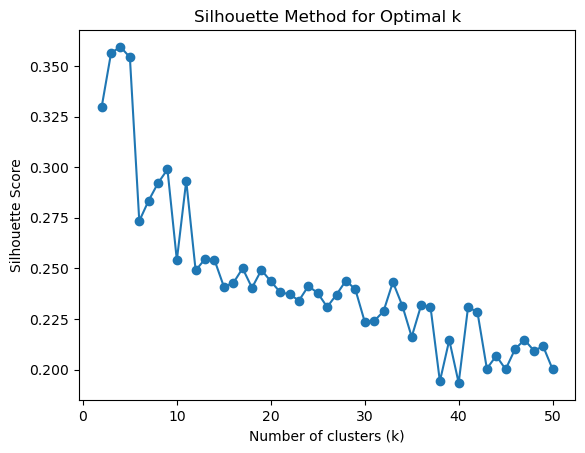

In [17]:
plt.plot(range_n_clusters, silhouette_scores, marker='o')
plt.title('Silhouette Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.show()

In [19]:
enc_k = OneHotEncoder(sparse_output=False)
Y_bin = enc_k.fit_transform(Y_k)

In [20]:
num_runs = 50
hamming_scores = []

for i in range(num_runs):
    kmeans = KMeans(n_clusters=best_k, n_init=10, random_state=i)
    clusters = kmeans.fit_predict(X_scaled_k)
    
    Y_pred = np.zeros_like(Y_k, dtype=object)
    
    for c in np.unique(clusters):
        mask = clusters == c
        for j, col in enumerate(Y_k.columns):
            Y_pred[mask, j] = Y_k[col][mask].mode()[0]

    Y_pred_df = pd.DataFrame(Y_pred, columns=Y_k.columns)
    Y_pred_bin = enc.transform(Y_pred_df)
    
    hamming_scores.append(hamming_loss(Y_bin, Y_pred_bin))
    
print(f"Average Hamming Distance over 50 runs: {np.mean(hamming_scores):.4f}")
print(f"Standard Deviation: {np.std(hamming_scores):.4f}")


Average Hamming Distance over 50 runs: 0.0668
Standard Deviation: 0.0032


### (b) Determine which family is the majority

In [22]:
cluster_summary = {}

for c in np.unique(clusters):
    mask = clusters == c
    subset = Y_k[mask]      
    
    majority_family  = subset['Family'].mode()[0]
    majority_genus   = subset['Genus'].mode()[0]
    majority_species = subset['Species'].mode()[0]

    cluster_summary[c] = {
        'Majority Family': majority_family,
        'Majority Genus': majority_genus,
        'Majority Species': majority_species,
        'Cluster Size': mask.sum()
    }

for c, info in cluster_summary.items():
    print(f"Cluster {c}:")
    print(f"  Size: {info['Cluster Size']}")
    print(f"  Majority Family : {info['Majority Family']}")
    print(f"  Majority Genus  : {info['Majority Genus']}")
    print(f"  Majority Species: {info['Majority Species']}")
    print()


Cluster 0:
  Size: 671
  Majority Family : Leptodactylidae
  Majority Genus  : Adenomera
  Majority Species: AdenomeraAndre

Cluster 1:
  Size: 2367
  Majority Family : Hylidae
  Majority Genus  : Hypsiboas
  Majority Species: HypsiboasCordobae

Cluster 2:
  Size: 3553
  Majority Family : Leptodactylidae
  Majority Genus  : Adenomera
  Majority Species: AdenomeraHylaedactylus

Cluster 3:
  Size: 604
  Majority Family : Hylidae
  Majority Genus  : Hypsiboas
  Majority Species: HypsiboasCinerascens



### (c) Calculate the average Hamming distance, Hamming score, and Hamming loss

In [23]:
Y_pred_h = np.zeros_like(Y_k, dtype=object)

for c in np.unique(clusters):
    mask = clusters == c
    Y_pred_h[mask, 0] = cluster_summary[c]['Majority Family']
    Y_pred_h[mask, 1] = cluster_summary[c]['Majority Genus']
    Y_pred_h[mask, 2] = cluster_summary[c]['Majority Species']

Y_pred_df_h = pd.DataFrame(Y_pred_h, columns=Y_k.columns)

Y_true_bin_h = enc.transform(Y_k)
Y_pred_bin_h = enc.transform(Y_pred_df_h)

hamming_loss_value_k = hamming_loss(Y_true_bin_h, Y_pred_bin_h)
hamming_score_k = 1 - hamming_loss_value_k
hamming_distance_k = hamming_loss_value_k

print(f"Hamming Loss: {hamming_loss_value_k:}")
print(f"Hamming Score: {hamming_score_k:}")
print(f"Average Hamming Distance: {hamming_distance_k:}")


Hamming Loss: 0.06748373238991724
Hamming Score: 0.9325162676100828
Average Hamming Distance: 0.06748373238991724


## 3. ISLR 12.6.2

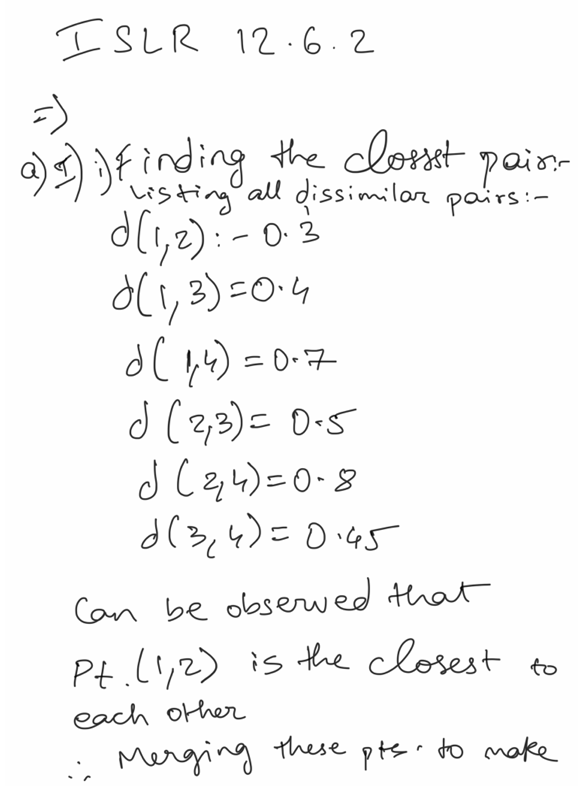
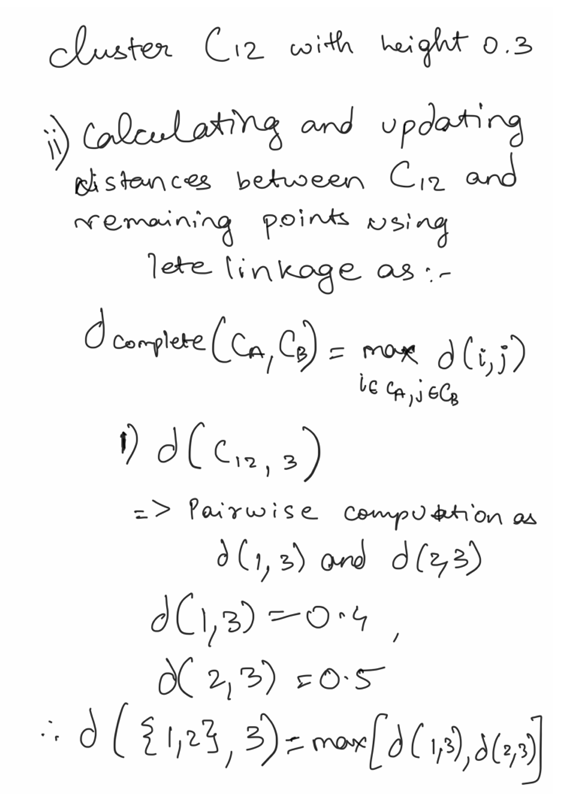
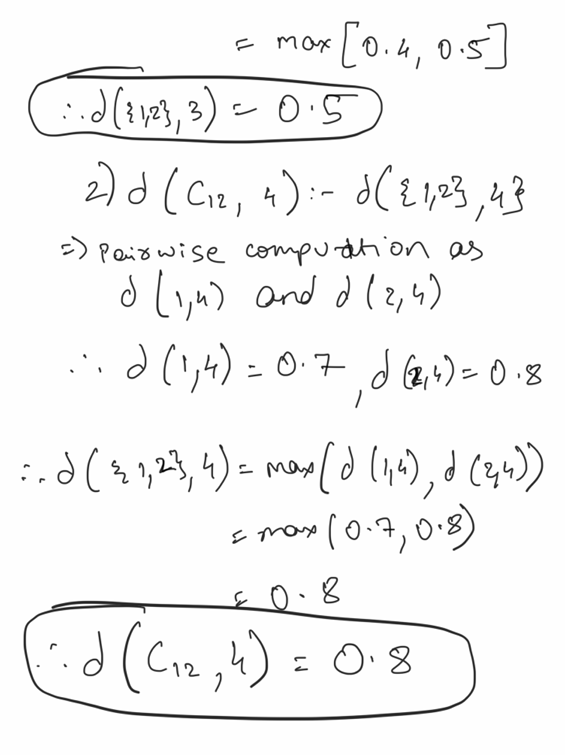
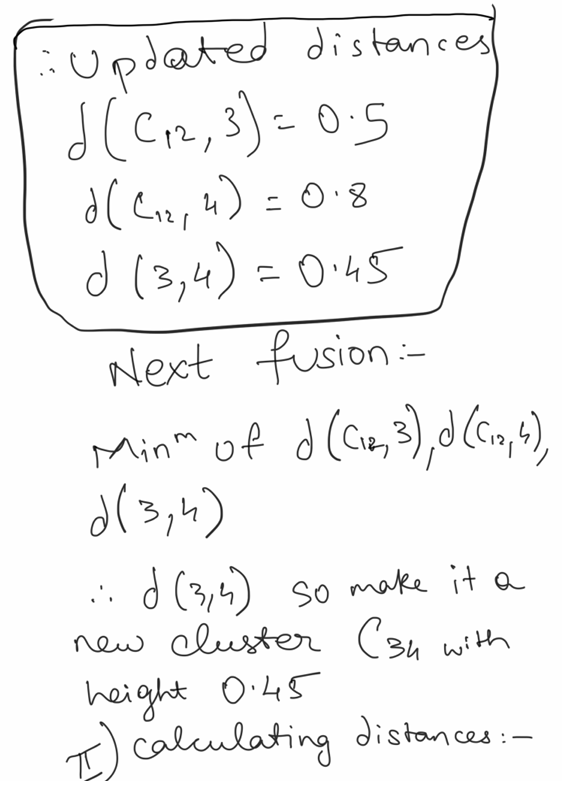
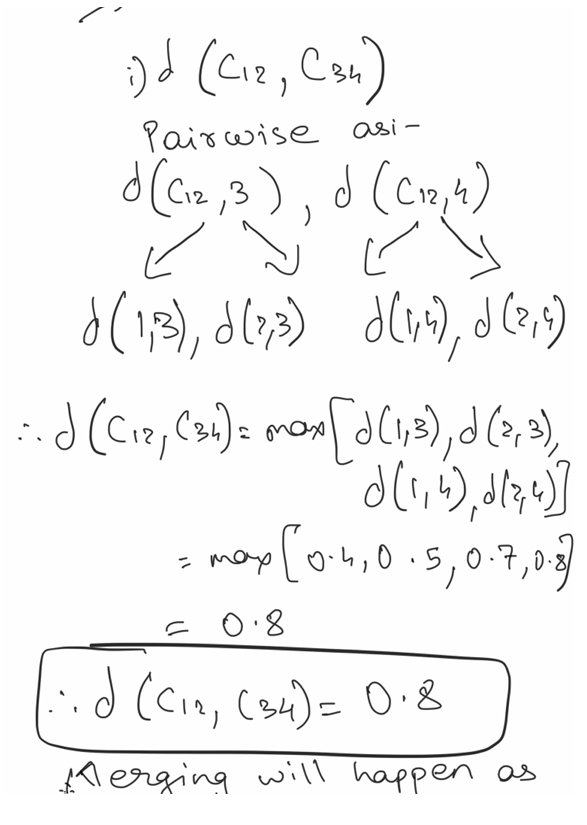
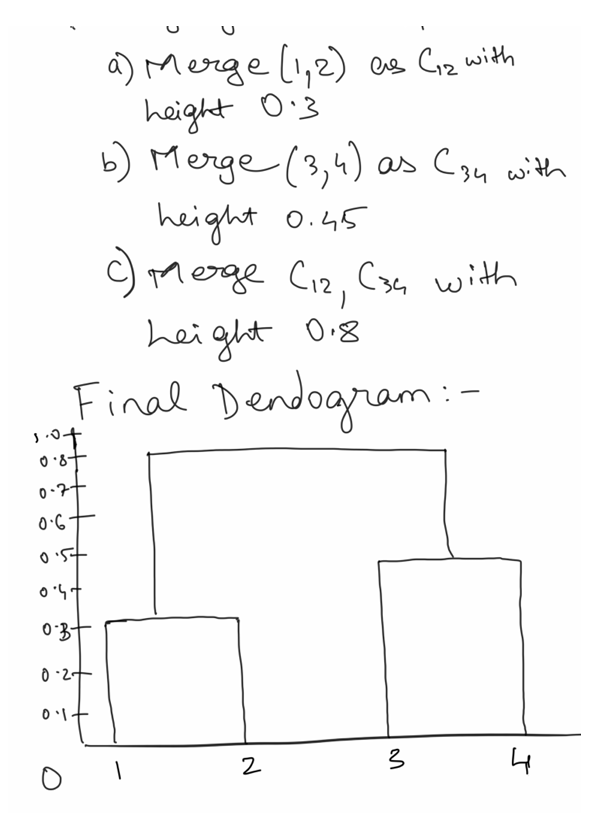
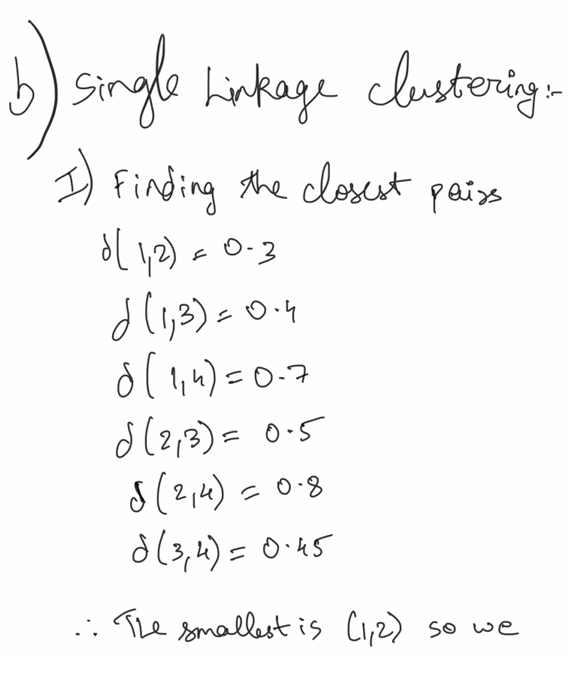
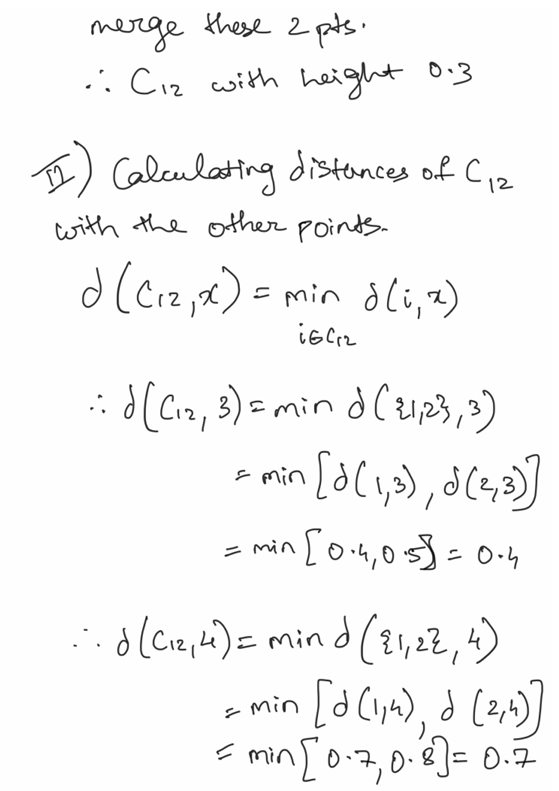
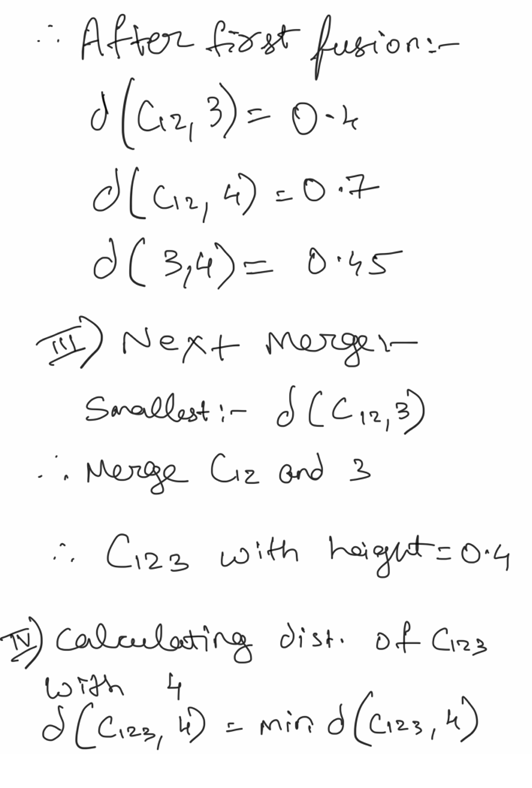
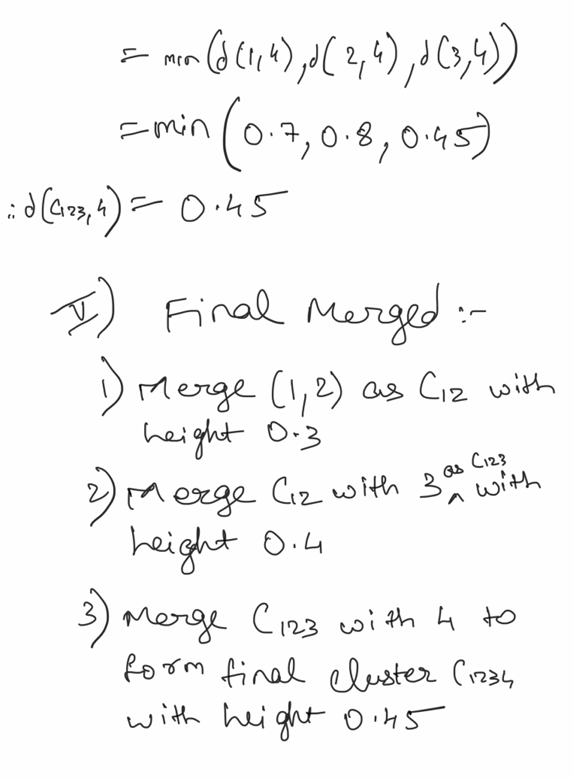
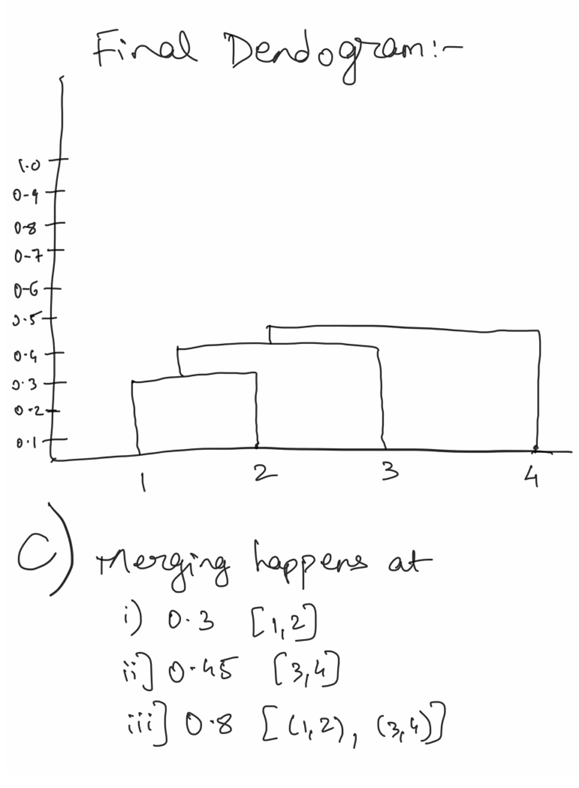
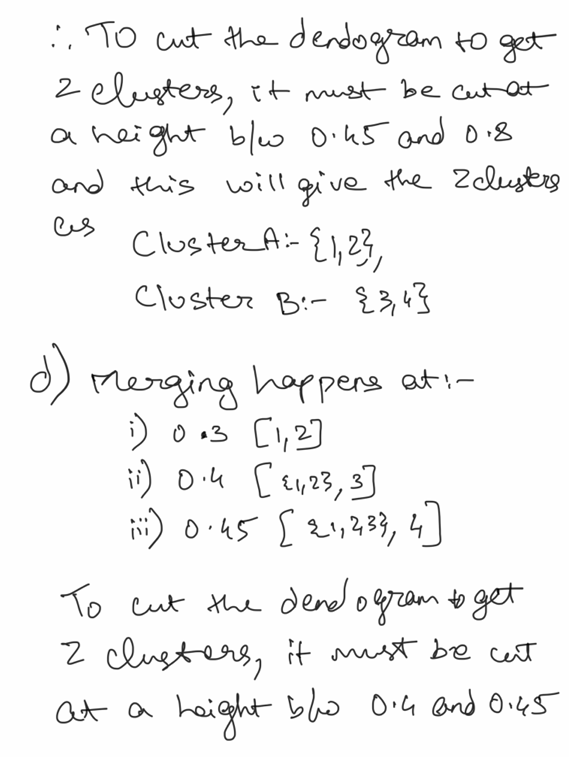
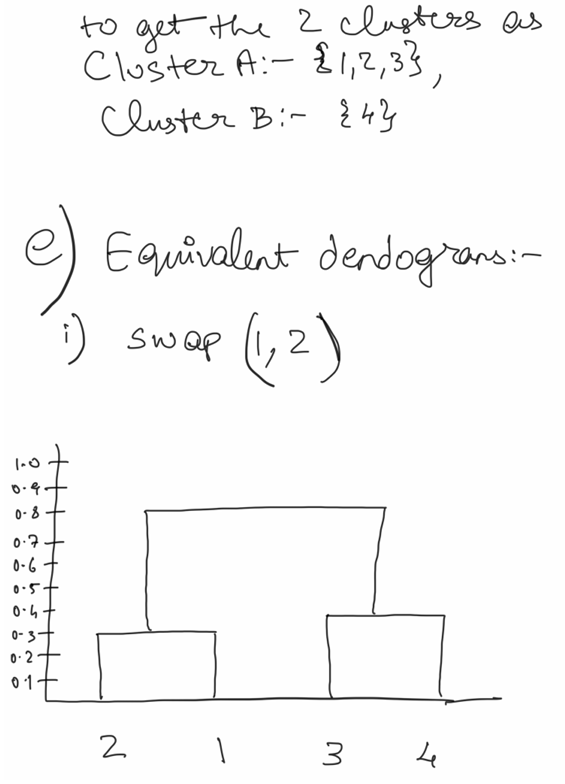
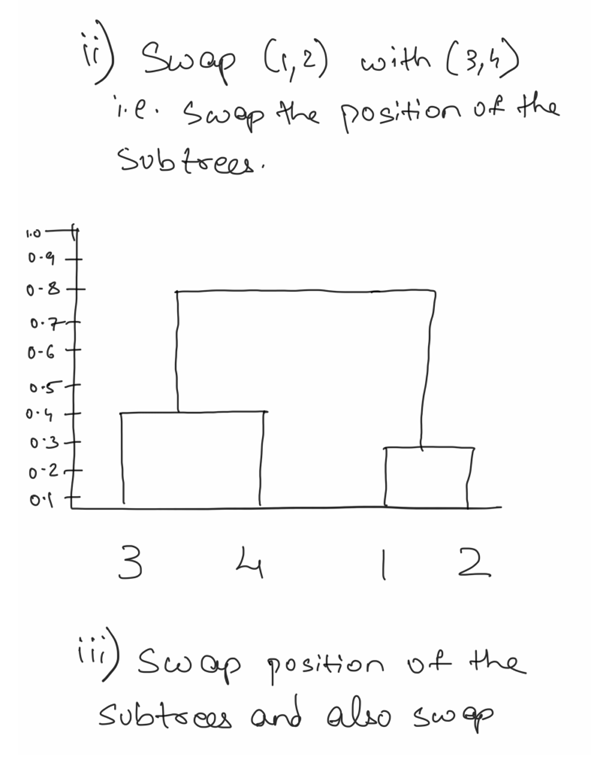
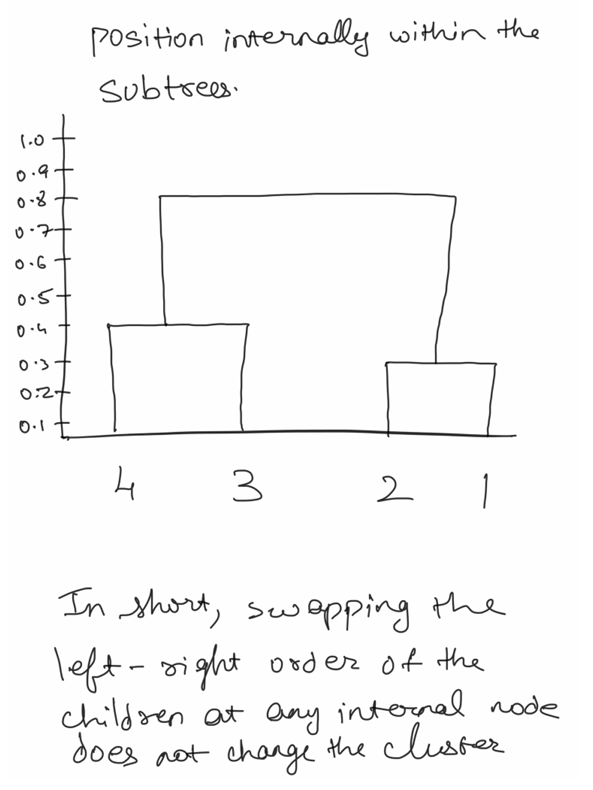
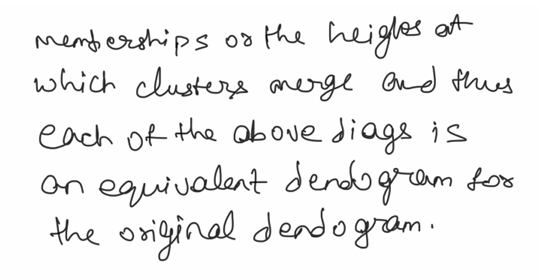